In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm

In [ ]:
file = '/global/cfs/projectdirs/atlas/hrzhao/qgcal/BDT_EPEML/pkls_etalabel/all_JZs_format1.pkl'
all_sample = pd.read_pickle(file)

In [ ]:
all_JZs_list = []
for key, value in all_sample.items():
    all_JZs_list.append(value)

all_jets = pd.concat(all_JZs_list)

In [ ]:
all_jets = all_jets.drop('event', axis = 1)

## Physical weights

In [ ]:
fig, ax = plt.subplots()
# pt_edges = np.linspace(500, 2000, 61)
pt_edges = np.linspace(500, 2000, 1501)
bin_contents, bin_edges, _ = ax.hist(all_jets['jet_pt'], bins=pt_edges, weights=all_jets['total_weight'])
ax.set_yscale('log')
plt.plot()


## Flatten Pt

### Plot

In [ ]:
flat_weight_factor = 1./bin_contents
pt_binned_sample_alljets_idx = np.digitize(all_jets['jet_pt'], pt_edges)

In [ ]:
all_jets['flatpt_weight'] = all_jets['total_weight']

In [ ]:
for i in tqdm(range(np.max(pt_binned_sample_alljets_idx))):
    mod_idx = np.where(pt_binned_sample_alljets_idx-1 == i)[0]
    all_jets.iloc[mod_idx, all_jets.columns.get_loc('flatpt_weight')] *= flat_weight_factor[i]
    ## df.iloc[0, df.columns.get_loc('COL_NAME')] = x

In [ ]:
fig, ax = plt.subplots()
pt_edges = np.linspace(500, 2000, 61)
bin_contents, bin_edges, _ = ax.hist(all_jets['jet_pt'], bins=pt_edges, weights=all_jets['flatpt_weight'])
# ax.set_yscale('log')
plt.plot()


### Adjust the columns 

In [ ]:
all_jets['equal_weight'] = np.ones(len(all_jets))

In [ ]:
all_jets.head()

In [ ]:
all_jets.rename(columns = {'total_weight':'event_weight'}, inplace = True)
col_list = list(all_jets)
print(col_list)

In [ ]:
insert_pos = col_list.index('event_weight')
adj_col_list = col_list[:insert_pos] + ['equal_weight'] + [col_list[insert_pos]] + [col_list[-2]] + col_list[insert_pos+2:-2]

In [ ]:
adj_col_list

In [ ]:
all_jets = all_jets.reindex(columns = adj_col_list)
all_jets = all_jets[all_jets['event_weight'] != 0]

In [ ]:
all_jets.head()

In [ ]:
all_jets.to_pickle("./sample_all_jets.pkl")

In [ ]:
with open("./sample_all_jets.pkl", 'rb') as f:
    all_jets = pd.read_pickle(f)

## Sample 1500GeV

### 2.8M jets

In [ ]:
sample_1500 = all_jets[(all_jets['jet_pt'] >= 1500) & (all_jets['jet_PartonTruthLabelID'] != -1)]

In [ ]:
sample_1500.head()

In [ ]:
sample_1500.describe()

In [ ]:
sample_1500.to_pickle("./sample_1500_all_jets.pkl")

In [ ]:
with open("./sample_1500_all_jets.pkl", 'rb') as f:
    test_sample = pd.read_pickle(f)

In [ ]:
sum(test_sample['target']==1)

In [ ]:
sum(test_sample['target']==0)

In [ ]:
sample_quark = sample_1500[sample_1500['target']==0]
sample_gluon = sample_1500[sample_1500['target']==1]

n_quark = len(sample_quark)
n_gluon = len(sample_gluon)

In [ ]:
n_sample = np.min([n_quark, n_gluon])

In [ ]:
subset_sample_quark = sample_quark.sample(n=n_sample)
subset_sample_gluon = sample_gluon.sample(n=n_sample)


In [ ]:
subset_sample_1500 = pd.concat([subset_sample_quark, subset_sample_gluon])

In [ ]:
len(subset_sample_1500)

In [ ]:
subset_sample_1500.to_pickle("./sample_1500_2p8M_jets.pkl")

### 200k jets

In [ ]:
all_jets = "./sample_all_jets.pkl" 

with open(all_jets, 'rb') as f:
    all_jets = pd.read_pickle(f)



In [ ]:
all_jets.head()

In [ ]:
sample_1500 = all_jets[(all_jets['jet_pt'] >= 1500) & (all_jets['jet_PartonTruthLabelID'] != -1)]

In [ ]:
n_sample = 100_000
sample_quark = sample_1500[sample_1500['target']==0]
sample_gluon = sample_1500[sample_1500['target']==1]
subset_sample_quark = sample_quark.sample(n=n_sample, random_state=42)
subset_sample_gluon = sample_gluon.sample(n=n_sample, random_state=42)
subset_sample_1500 = pd.concat([subset_sample_quark, subset_sample_gluon])
subset_sample_1500.to_pickle("./sample_1500_200k_jets.pkl")

In [ ]:
subset_sample_1500.tail()

# Sample 12M jets 

In [ ]:
all_jets = "./sample_all_jets.pkl" 

with open(all_jets, 'rb') as f:
    all_jets = pd.read_pickle(f)

In [ ]:
all_jets.shape

In [ ]:
all_jets.head()

In [ ]:
#### Remove 
all_jets = all_jets[(all_jets['jet_PartonTruthLabelID'] != -1) & (all_jets['jet_nTracks'] >= 2)]

In [ ]:
label_pt_bin = [500, 600, 800, 1000, 1200, 1500, 2000]
all_jets['pt_idx'] = pd.cut(x=all_jets['jet_pt'], bins=label_pt_bin, right=False, labels=False)


In [ ]:
all_jets

In [ ]:
quark_jets = all_jets[all_jets['target'] == 0]
gluon_jets = all_jets[all_jets['target'] == 1]
n_sample_ptbin = 1_000_000
jets_list = []

for jets in [quark_jets, gluon_jets]:
    for pt_idx, pt in enumerate(label_pt_bin[:-1]):
        jets_pt = jets[jets['pt_idx'] == pt_idx] 
        jets_list.append(jets_pt.sample(n=n_sample_ptbin, random_state = 42))

In [ ]:
jets_allpt_12M = pd.concat(jets_list)

In [ ]:
jets_allpt_12M.shape

In [ ]:
jets_allpt_12M.to_pickle("./sample_allpt_12M_jets.pkl")

# Sampling study

In [2]:
all_jets = "./sample_allpt_all_jets.pkl" 

with open(all_jets, 'rb') as f:
    all_jets = pd.read_pickle(f)

In [16]:
np.sum(all_jets['pt_idx'] == 5)

5194577

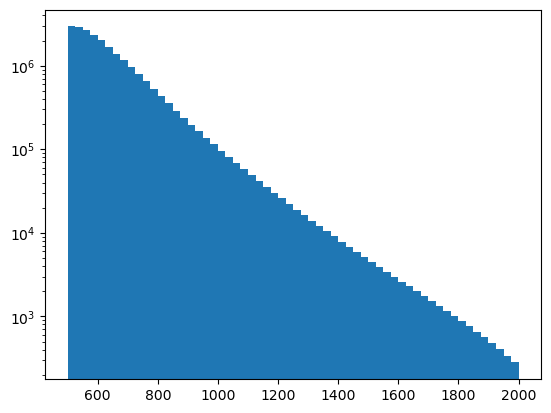

In [7]:
pt_edges = np.linspace(500,2000,61)

plt.hist(all_jets['jet_pt'], weights=all_jets['event_weight'], bins=pt_edges)
plt.yscale('log')

(array([0.99960947, 0.9996304 , 0.99963877, 0.9996385 , 0.99969095,
        0.99966896, 0.99967284, 0.99967554, 0.99965784, 0.99968719,
        0.99967585, 0.9996743 , 0.99970825, 0.99969044, 0.99970302,
        0.99965722, 0.99973327, 0.99968853, 0.99969676, 0.99967845,
        0.99970575, 0.99966276, 0.99972429, 0.9996968 , 0.99971206,
        0.99965132, 0.99968923, 0.99974075, 0.99967762, 0.99970383,
        0.99958451, 0.99967649, 0.99969626, 0.99969135, 0.99963622,
        0.99976598, 0.999732  , 0.99974081, 0.99942842, 0.99953506,
        0.99930776, 0.99972259, 0.99970338, 0.99952576, 0.99968727,
        0.99970766, 0.99971755, 0.99972547, 0.99971309, 0.99953578,
        0.99976512, 0.99972297, 0.9997393 , 0.99977398, 0.99973001,
        0.99979788, 0.99969829, 0.99974078, 0.9996939 , 0.99973959]),
 array([ 500.,  525.,  550.,  575.,  600.,  625.,  650.,  675.,  700.,
         725.,  750.,  775.,  800.,  825.,  850.,  875.,  900.,  925.,
         950.,  975., 1000., 1025., 1050

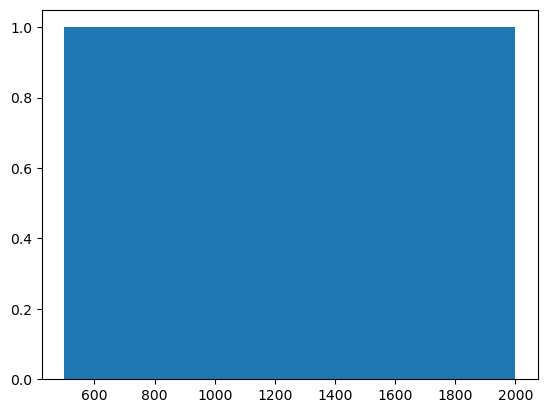

In [9]:
plt.hist(all_jets['jet_pt'], weights=all_jets['flatpt_weight'], bins=pt_edges)

## Sample 1 & Sample 2 & Sample 3

In [17]:
n_sample = 5_000_000
sample123 = all_jets.sample(n_sample, random_state = 42)

In [18]:
sample123

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,is_forward,pt_idx,target
3040225,1771.308105,-1.185907,24.0,0.111155,0.297679,-0.001197,1.0,1.0,0.002129,1.832609e-06,1.0,5,0.0
3308762,576.650024,-1.632921,18.0,0.030110,0.227651,0.115335,21.0,1.0,0.954678,4.073045e-07,1.0,0,1.0
24589109,549.962463,-0.248085,12.0,0.028959,0.142942,-0.211451,4.0,1.0,0.534956,1.849374e-07,0.0,0,0.0
6893257,926.854065,0.773220,11.0,0.022511,0.151775,-0.290329,2.0,1.0,0.130191,7.915768e-07,1.0,2,0.0
729798,1347.683838,-0.424933,20.0,0.046835,0.199852,-0.123005,2.0,1.0,0.039094,3.223083e-06,1.0,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5934631,1418.605103,-0.030457,23.0,0.024651,0.215973,0.101285,1.0,1.0,0.010488,1.333070e-06,0.0,4,0.0
1911342,1472.617310,-0.040862,12.0,0.021771,0.186129,-0.315558,1.0,1.0,0.019527,3.299834e-06,0.0,4,0.0
3571118,742.186401,0.298260,29.0,0.092861,0.305258,0.230719,2.0,1.0,0.328265,4.132454e-07,0.0,1,0.0
1343063,686.528320,1.423474,11.0,0.023117,0.156143,-0.284020,3.0,1.0,0.757037,6.527034e-07,1.0,1,0.0


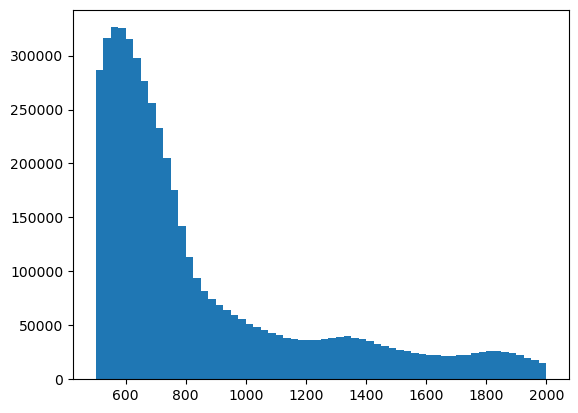

In [38]:
_, _, _ = plt.hist(sample123['jet_pt'], bins=pt_edges, weights=sample123['equal_weight'])

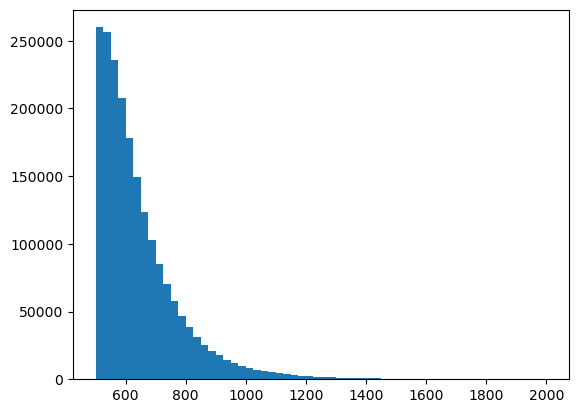

In [39]:
_, _, _ = plt.hist(sample123['jet_pt'], bins=pt_edges, weights=sample123['event_weight'])

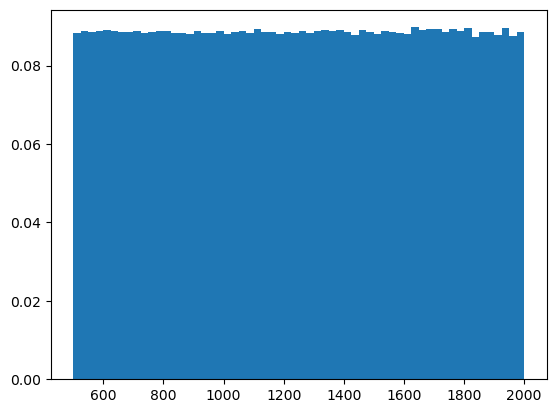

In [40]:
_, _, _ = plt.hist(sample123['jet_pt'], bins=pt_edges, weights=sample123['flatpt_weight'])

In [19]:
sample123.to_pickle('sample_testweight_123')

## Sample 4

In [23]:
sample4 = all_jets[all_jets['pt_idx'] == 5].sample(n_sample, random_state = 42)

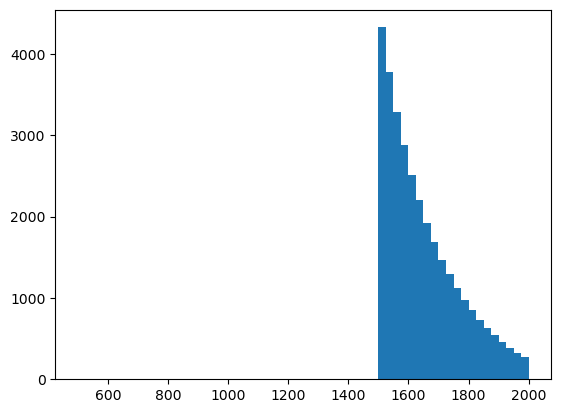

In [15]:
_, _, _ = plt.hist(sample4['jet_pt'], bins=np.linspace(500,2000,61), weights=sample4['event_weight'])

In [24]:
sample4.to_pickle('sample_testweight_4')

## Sample 5

### Test 1

In [27]:
n_subsample = n_sample // 6 + 1

In [33]:
sample5 = []
for i in range(6):
    sub_sample = all_jets[all_jets['pt_idx'] == i]
    sample5.append(sub_sample.sample(n_subsample))

In [34]:
sample5 = pd.concat(sample5)

In [35]:
sample5

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,is_forward,pt_idx,target
4749020,558.778503,1.956218,8.0,0.044092,0.164873,-0.270062,1.0,1.0,0.885801,3.326282e-07,1.0,0,0.0
2058161,500.227051,-0.700610,14.0,0.058007,0.215849,-0.039104,21.0,1.0,3.155823,1.070734e-06,1.0,0,1.0
14032818,599.915588,-0.085527,12.0,0.034032,0.210441,-0.146284,21.0,1.0,0.526725,2.247224e-07,0.0,0,1.0
14436708,552.810852,0.905856,26.0,0.040498,0.212690,0.229917,1.0,1.0,1.106593,4.155380e-07,1.0,0,0.0
6280879,553.033203,0.611263,22.0,0.037585,0.194696,0.166960,21.0,1.0,0.610068,2.290875e-07,0.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4550265,1635.989746,0.241327,31.0,0.071800,0.239992,0.049261,21.0,1.0,0.010086,4.414716e-06,0.0,5,1.0
5161788,1547.495972,-1.078493,26.0,0.015637,0.076848,0.032070,2.0,1.0,0.015814,4.033881e-06,1.0,5,0.0
4123698,1747.022339,0.353280,12.0,0.011660,0.050748,-0.498818,3.0,1.0,0.011906,8.898059e-06,1.0,5,0.0
468527,1766.292236,-0.908060,28.0,0.016022,0.161772,0.179349,1.0,1.0,0.008076,6.953024e-06,1.0,5,0.0


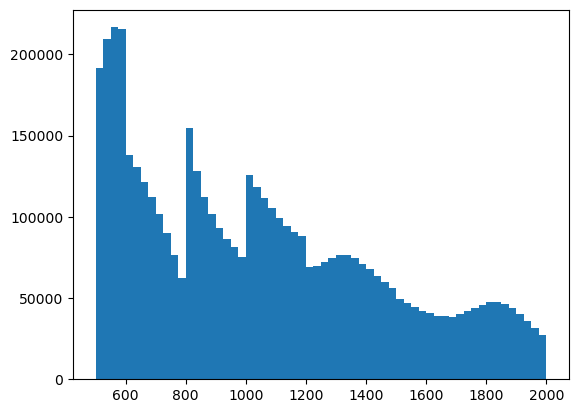

In [43]:
_, _, _ =plt.hist(sample5['jet_pt'], bins=pt_edges, weights=sample5['equal_weight'])

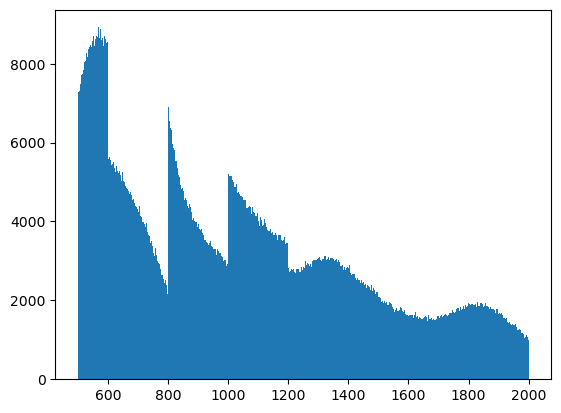

In [44]:
_, _, _ =plt.hist(sample5['jet_pt'], bins=np.linspace(500, 2000, 1501), weights=sample5['equal_weight'])

In [ ]:
sample5 = []
for i in range(6):
    sub_sample = all_jets[all_jets['pt_idx'] == i]
    sample5.append(sub_sample.sample(n_subsample))

### Test 2

In [66]:
label_pt_bin = np.array([500, 600, 800, 1000, 1200, 1500, 2000])
ratio = (np.diff(label_pt_bin) / (label_pt_bin[-1] - label_pt_bin[0]))
ratio = ratio/ np.sum(ratio)

In [67]:
n_subsample = n_sample * ratio

In [68]:
n_subsample

array([ 333333.33333333,  666666.66666667,  666666.66666667,
        666666.66666667, 1000000.        , 1666666.66666667])

In [69]:
sample5_test2 = []
for i in range(6):
    sub_sample = all_jets[all_jets['pt_idx'] == i]
    sample5_test2.append(sub_sample.sample(int(n_subsample[i])))

In [70]:
sample5_test2 = pd.concat(sample5_test2)

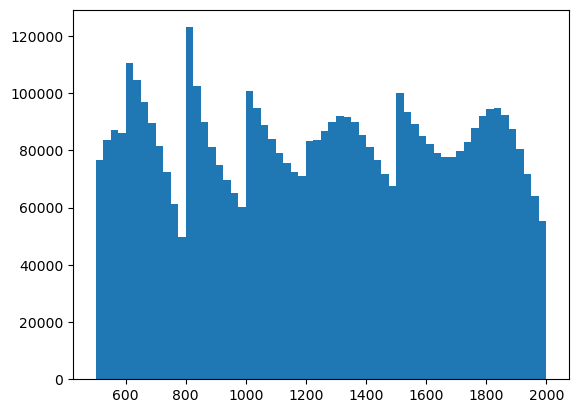

In [71]:
_, _, _ =plt.hist(sample5_test2['jet_pt'], bins=pt_edges, weights=sample5_test2['equal_weight'])

In [73]:
sample5_test2.to_pickle('sample_testweight_5_test2')

In [ ]:
# fine_pt_bin = np.linspace(500, 2000, 1501)
# n_sample_fine_pt = n_sample // 1501 + 1
# all_jets2 = all_jets.copy()
# all_jets2['fine_pt_idx'] = pd.cut(x=all_jets2['jet_pt'], bins=fine_pt_bin, right=False, labels=False)
# n_sample_fine_pt

# sample5_test2 = []
# for i in tqdm(range(1501)):
#     sub_sample = all_jets2[all_jets2['fine_pt_idx'] == i]
#     sample5_test2.append(all_jets2.sample(n_sample_fine_pt))

## Make 2 test samples

In [74]:
n_test_sample = 500_000 # 0.5 M 
sample_testweight_testsample1 = all_jets[all_jets['pt_idx'] == 0].sample(n_test_sample, random_state = 101)
sample_testweight_testsample1.to_pickle('sample_testweight_testsample1')


### update on test sample2

In [2]:
#### This is because the whole number of jets in 1500GeV to 2000GeV is 5M, and the following commented is choose many seen samples  

# sample_testweight_testsample2 = all_jets[all_jets['pt_idx'] == 5].sample(n_test_sample, random_state = 101)
# sample_testweight_testsample2.to_pickle('sample_testweight_testsample2')

from sklearn.model_selection import train_test_split
sample4 = pd.read_pickle('sample_testweight_4')
sample_dev, sample4_test = train_test_split(sample4, test_size=0.1, random_state=456)
sample4_test.to_pickle('sample_testweight_testsample2')